In [ ]:
from ultralytics import YOLO
from ultralytics.engine.results import Results

# Load a model
# model = YOLO("/mnt/d/models/ultralytic/yolo11n-pose.pt") 
# model = YOLO("/mnt/d/models/ultralytic/YOLO11x-pose.pt") 
model = YOLO("/mnt/d/runs/pose/train18/weights/best.pt") 
# load an official model
# model = YOLO("path/to/best.pt")  # load a custom model

# Predict with the model
# results = model("/mnt/c/Users/PC/Downloads/bus.jpg")  # predict on an image
results = model("/mnt/d/datasets/animal_pose/ultralytics_format/images/train/do110.jpg")

# Access the results
# for result in results:
#     xy = result.keypoints.xy  # x and y coordinates
#     xyn = result.keypoints.xyn  # normalized
#     kpts = result.keypoints.data  # x, y, visibility (if available)
#     print(f"xy={xy}, xyn={xyn}, kpts={kpts}")
    


image 1/1 /mnt/d/datasets/animal_pose/ultralytics_format/images/train/do110.jpg: 512x640 1 dog, 96.5ms
Speed: 3.6ms preprocess, 96.5ms inference, 173.3ms postprocess per image at shape (1, 3, 512, 640)


# pose models


image 1/1 /mnt/d/datasets/animal_pose/ultralytics_format/images/val/co96.jpg: 608x640 1 cow, 99.6ms
Speed: 9.2ms preprocess, 99.6ms inference, 8.8ms postprocess per image at shape (1, 3, 608, 640)


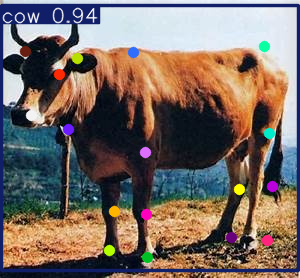

In [ ]:
# results = model("/mnt/d/datasets/animal_pose/ultralytics_format/images/train/co67.jpg")  # predict on an image
# results: list[Results] = model("../images/2.jpg")

results = model("/mnt/d/datasets/animal_pose/ultralytics_format/images/val/co96.jpg")  # predict on an image

# Access the results
# for result in results:
#     xy = result.keypoints.xy  # x and y coordinates
#     xyn = result.keypoints.xyn  # normalized
#     kpts = result.keypoints.data  # x, y, visibility (if available)
#     print(f"xy={xy}, xyn={xyn}, kpts={kpts}")
    
for result in results:
    # print(result.boxes.xywh)
    # print(result.obb)
    # print(result.keypoints.cpu().numpy().shape)
    # print("a key point:", result.keypoints.cpu().numpy()[0:1,0:1,:])
    result.show()

In [ ]:
model.names

{0: 'dog', 1: 'cat', 2: 'sheep', 3: 'horse', 4: 'cow'}

# detection models

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
# model = YOLO("/mnt/d/models/ultralytic/yolo11x.pt")
model = YOLO("/mnt/d/models/ultralytic/yolo11n.pt")

# Define path to the image file
# source = "../../cv2/images/white_pig_blue_ruler.png"
source = "../images/dogs.jpg"

# Run inference on the source
results = model(source)  # list of Results objects


image 1/1 /mnt/d/code/learn/pylearn/ML/images/pose_dection_keypoints/../images/dogs.jpg: 640x640 3 dogs, 18.3ms
Speed: 7.7ms preprocess, 18.3ms inference, 234.2ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
model.names

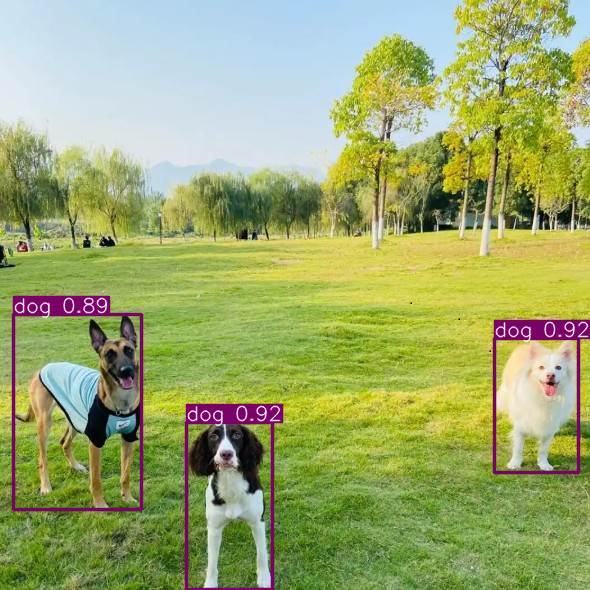

In [ ]:
for result in results:
    # print(result.boxes)
    result.show()

## onnx python调用

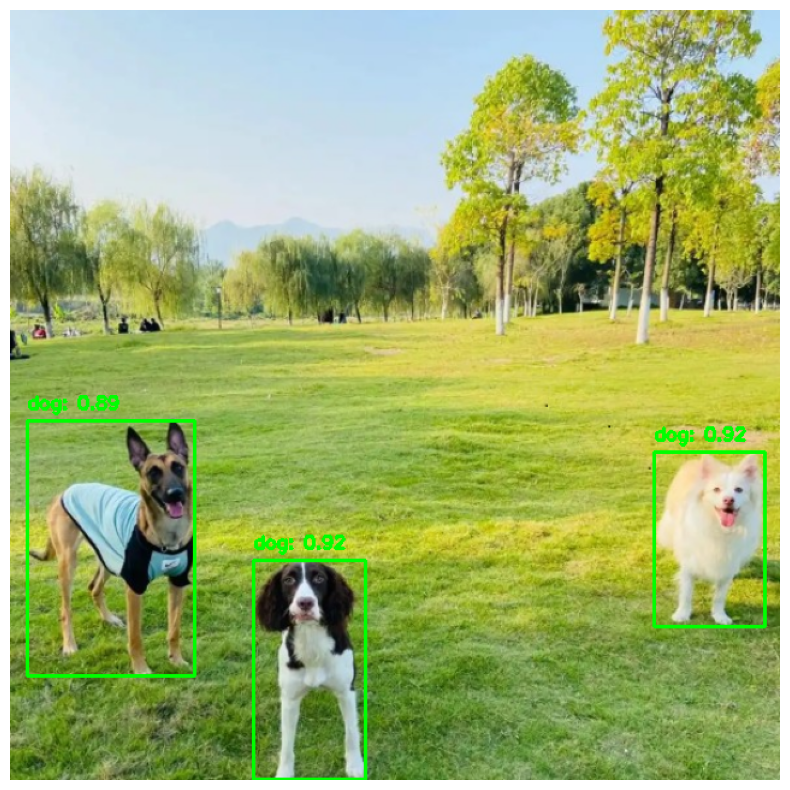

In [13]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

# 类别名称列表，这里假设是 COCO 数据集的 80 个类别
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
    'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def preprocess_image(image, input_size):
    """
    图像预处理函数
    :param image: 输入的图像（BGR 格式）
    :param input_size: 模型输入的尺寸 (w, h)
    :return: 预处理后的图像张量
    """
    # 转换为 RGB 格式
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 调整图像大小
    resized_image = cv2.resize(image, input_size)
    # 归一化
    input_image = resized_image / 255.0
    # 增加批次维度
    input_image = np.expand_dims(input_image.transpose(2, 0, 1), axis=0).astype(np.float32)
    return resized_image, input_image

def postprocess(outputs, conf_threshold=0.5, iou_threshold=0.4):
    """
    后处理函数，包括过滤低置信度检测结果和非极大值抑制
    :param outputs: 模型的输出
    :param conf_threshold: 置信度阈值
    :param iou_threshold: 交并比阈值
    :return: 过滤后的边界框、置信度和类别索引
    """
    predictions = outputs[0]
    boxes = []
    scores = []
    class_ids = []

    predictions = predictions[0].T # 输出维度为 (8400, 84)
    # 遍历每个检测结果
    for pred in predictions:
        # 提取置信度
        # obj_conf = pred[4]
        class_probs = pred[4:]
        class_score = np.max(class_probs)
        class_id = np.argmax(class_probs)
        # confidence = obj_conf * class_score  # 最终的置信度是目标置信度和类别概率的乘积
        confidence = class_score 

        if confidence > conf_threshold:
            x_center, y_center, width, height = pred[:4]
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            boxes.append([x1, y1, x2, y2])
            scores.append(confidence)
            class_ids.append(class_id)

    # 非极大值抑制
    indices = cv2.dnn.NMSBoxes(boxes, scores, conf_threshold, iou_threshold)
    final_boxes = []
    final_scores = []
    final_class_ids = []
    for i in indices:
        i = i.item()
        final_boxes.append(boxes[i])
        final_scores.append(scores[i])
        final_class_ids.append(class_ids[i])

    return final_boxes, final_scores, final_class_ids

def draw_boxes(image, boxes, scores, class_ids, classes):
    """
    在图像上绘制检测结果
    :param image: 输入的图像（RGB 格式）
    :param boxes: 边界框列表
    :param scores: 置信度列表
    :param class_ids: 类别索引列表
    :param classes: 类别名称列表
    :return: 绘制了检测结果的图像
    """
    for box, score, class_id in zip(boxes, scores, class_ids):
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f'{classes[class_id]}: {score:.2f}'
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

def main():
    # 加载 ONNX 模型
    onnx_path = '/mnt/d/tmp/yolo11n.onnx'  # 替换为你的 ONNX 模型路径
    session = ort.InferenceSession(onnx_path)

    # 获取输入和输出名称
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    # 加载图像
    image_path = '../images/dogs.jpg'  # 替换为你的图像路径
    image = cv2.imread(image_path)

    # 预处理图像
    input_size = (640, 640)
    resized_image, input_image = preprocess_image(image, input_size)

    # 运行推理
    outputs = session.run([output_name], {input_name: input_image})

    # 后处理
    boxes, scores, class_ids = postprocess(outputs)

    # 将图像转换为 RGB 格式用于 plt 显示
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 绘制检测结果
    result_image = draw_boxes(resized_image, boxes, scores, class_ids, COCO_CLASSES)

    # 使用 plt 显示结果
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()


main()

# segmentation

## seg model 中如何得到分类

* print(results[0].boxes.cls)


In [ ]:
from ultralytics import YOLO
from ultralytics.engine.results import Results
# Load a pretrained YOLO11n model
model = YOLO("/mnt/d/models/ultralytic/yolo11x-seg.pt")


In [ ]:
from ultralytics.engine.results import Results
# Define path to the image file
source = "../../cv2/images/white_pig_blue_ruler.png"
source = "/mnt/d/wps/公司项目/黄丕元/pig_data/2月19日江夏拍摄素材照片/19/2502190855335262.jpg"
source = "/mnt/d/wps/公司项目/黄丕元/pig_data/2月19日江夏拍摄素材照片/19/2502190905458376.jpg"
source = "/mnt/d/wps/公司项目/黄丕元/pig_data/2月19日江夏拍摄素材照片/19/2502190951119220.jpg"
# Run inference on the source
results: list[Results] = model(source)  # list of Results objects



image 1/1 /mnt/d/wps/公司项目/黄丕元/pig_data/2月19日江夏拍摄素材照片/19/2502190951119220.jpg: 640x352 1 cat, 1 remote, 305.1ms
Speed: 7.3ms preprocess, 305.1ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 352)


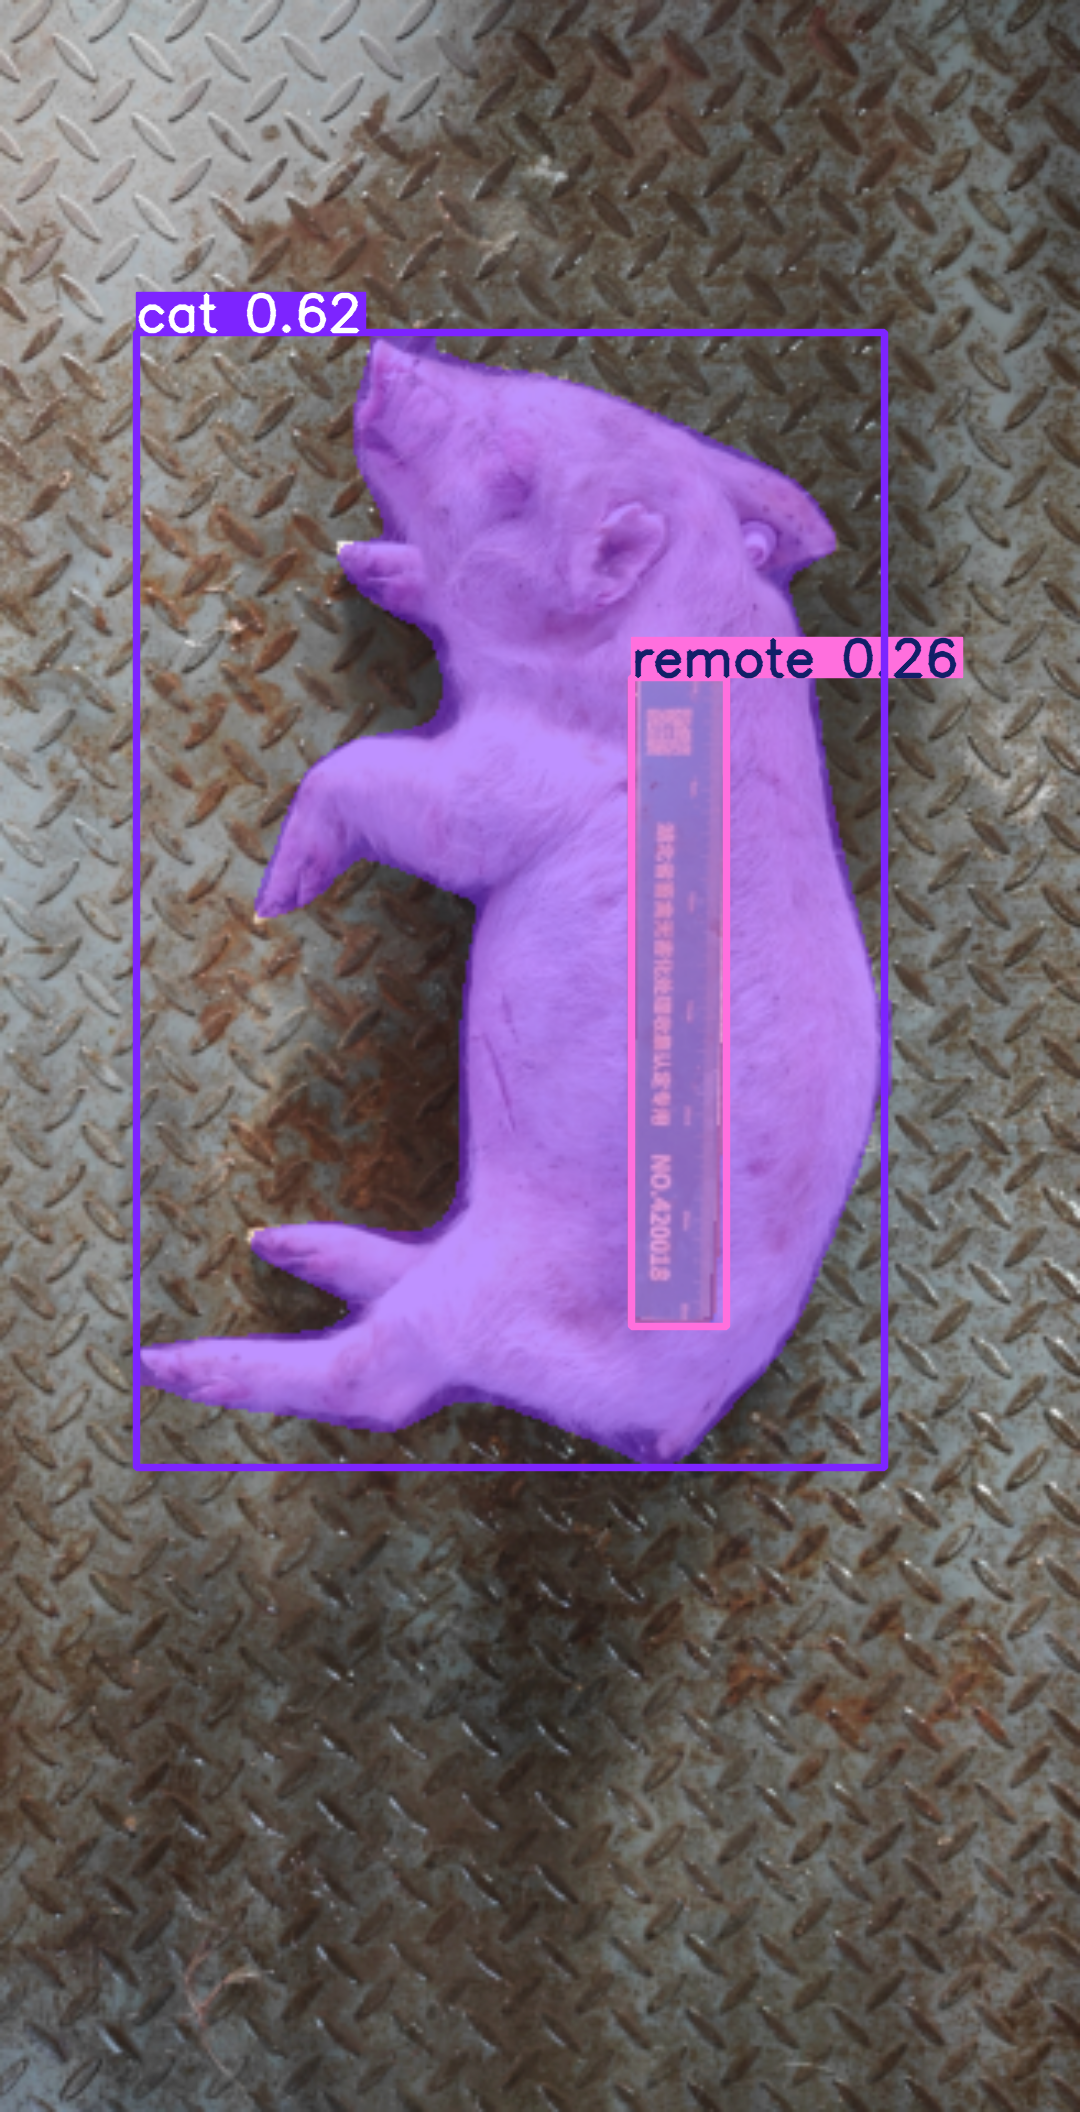

In [ ]:
for result in results:
    # print(result.data.sum().cpu())
    result.show()

# results[0].cpu().boxes

In [ ]:
len(results)

In [ ]:
# model.names
from ultralytics.utils import SETTINGS

print(SETTINGS)


# OBB

In [ ]:
from ultralytics import YOLO
from ultralytics.engine.results import Results

# Load a model
model = YOLO("/mnt/d/models/ultralytic/yolo11x-obb.pt") 


image 1/1 /mnt/d/code/learn/pylearn/ML/images/pose_dection_keypoints/../images/dota.png: 768x1024 262.7ms
Speed: 15.2ms preprocess, 262.7ms inference, 8.2ms postprocess per image at shape (1, 3, 768, 1024)


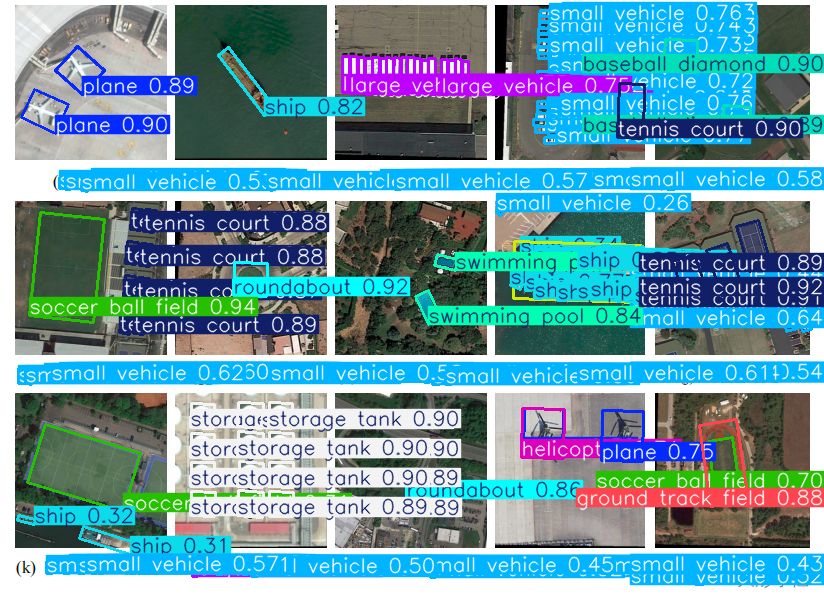

In [ ]:
# Predict with the model
# results = model("/mnt/c/Users/PC/Downloads/bus.jpg")  # predict on an image

# Access the results
# for result in results:
#     xy = result.keypoints.xy  # x and y coordinates
#     xyn = result.keypoints.xyn  # normalized
#     kpts = result.keypoints.data  # x, y, visibility (if available)
#     print(f"xy={xy}, xyn={xyn}, kpts={kpts}")

# results: list[Results]  = model("../../cv2/images/white_pig_blue_ruler.png")  # predict on an image
# results: list[Results] = model("../images/planes.png")
results: list[Results] = model("../images/dota.png")
# Access the results
# for result in results:
#     xy = result.keypoints.xy  # x and y coordinates
#     xyn = result.keypoints.xyn  # normalized
#     kpts = result.keypoints.data  # x, y, visibility (if available)
#     print(f"xy={xy}, xyn={xyn}, kpts={kpts}")
    
for result in results:
    # print(result.boxes.xywh)
    # print(result.obb)
    # print(result.keypoints.cpu().numpy().shape)
    # print("a key point:", result.keypoints.cpu().numpy()[0:1,0:1,:])
    result.show()

In [ ]:
results[0]

# finetune

## detection

In [ ]:
from ultralytics import YOLO

# Load YOLO11n model from configure
model = YOLO("/home/jeffye/yolo11.yaml")
# model = YOLO("/mnt/d/models/ultralytic/yolo11x-seg.pt")
# load pretrained parameters
model.load("/mnt/d/models/ultralytic/yolo11n.pt") 



In [ ]:
from ultralytics.engine.results import Results
from ultralytics.engine.results import Masks

# model.load("runs/detect/train4/weights/best.pt")


# Define path to the image file
source = "../images/2.jpg"
source = "/home/jeffye/datasets/coco8/images/train/000000000009.jpg"

# Run inference on the source
results: list[Results] = model(source)  # list of Results objects

In [ ]:
for result in results:
    # print(result.data.sum().cpu())
    result.show()

In [ ]:
print(results[0].boxes)

In [ ]:
# finetune

# Train the model
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
device="cuda"
results = model.train(data="/home/jeffye/coco8.yaml", epochs=30, device=device)

In [ ]:
print(model.names)

## finetune pose model

In [ ]:
from ultralytics import YOLO

# Load YOLO11n model from configure
model = YOLO("/home/jeffye/yolo11.yaml")
# model = YOLO("/mnt/d/models/ultralytic/yolo11x-seg.pt")
# load pretrained parameters
model.load("/mnt/d/models/ultralytic/yolo11n.pt") 

# Train the model
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
device="cuda"
results = model.train(data="/home/jeffye/coco8.yaml", epochs=30, device=device)

# notes

## 各模块参数解释

* https://github.com/ultralytics/ultralytics/blob/main/docs/en/macros/train-args.md

## config

```(base) [jeffye:pig_estimation]$ yolo settings
JSONDict("/home/jeffye/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/mnt/d/datasets",
  "weights_dir": "weights",
  "runs_dir": "/mnt/d/runs",
  "uuid": "30c88cbfc76095c5753b0bd7f982d4b37492ba4707a8796216e1133786b6b726",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}```